In [11]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import math
import joypy
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.feature_selection import SelectFromModel
from datetime import datetime
import matplotlib.ticker as ticker
from matplotlib.legend_handler import HandlerLine2D
#import ray 


# py -m pip install matplotlib

In [12]:
df_private_MTPL = pd.read_csv('df_private_mtpl2.txt', sep="\t")

In [13]:
df_private_MTPL.head(5)

PRODUCT Duration  Vehicle_age  Make    GWP vehicle_type_group_mapped  \
0     MOD     Long          7.0    VW  38.67               6) Personal   
1     MOD     Long          4.0   KIA  24.59               6) Personal   
2     MOD     Long          4.0   KIA  24.55               6) Personal   
3     MOD     Long         11.0  FORD  31.42               6) Personal   
4     MOD     Long         11.0  FORD  31.44               6) Personal   

   number_of_claims      Channel  Churn  Renewal  Policy_Duration  Gender  \
0               0.0       Broker      0        1            364.0    Male   
1               1.0  Own Network      0        1            364.0  Female   
2               1.0  Own Network      0        1            364.0  Female   
3               1.0       Broker      0        1            364.0    Male   
4               1.0       Broker      0        1            364.0    Male   

   Client_Age     City  Years_of_driving  
0        38.0    Other                18  
1        45.0  Vilnius                24  
2        45.0  Vilnius                24  
3        38.0  Vilnius                18  
4        38.0  Vilnius                18

In [14]:
df_private_MTPL['Vehicle_age'] = pd.to_numeric(df_private_MTPL['Vehicle_age'], errors='coerce')
df_private_MTPL['GWP'] = pd.to_numeric(df_private_MTPL['GWP'], errors='coerce')
df_private_MTPL['number_of_claims'] = pd.to_numeric(df_private_MTPL['number_of_claims'], errors='coerce')
df_private_MTPL['Client_Age'] = pd.to_numeric(df_private_MTPL['Client_Age'], errors='coerce')
df_private_MTPL['Policy_Duration'] = pd.to_numeric(df_private_MTPL['Policy_Duration'], errors='coerce')
df_private_MTPL['Years_of_driving'] = pd.to_numeric(df_private_MTPL['Years_of_driving'], errors='coerce')

df_private_MTPL['PRODUCT'] = pd.Categorical(df_private_MTPL['PRODUCT'])
df_private_MTPL['Duration'] = pd.Categorical(df_private_MTPL['Duration'])
df_private_MTPL['Make'] = pd.Categorical(df_private_MTPL['Make'])
df_private_MTPL['vehicle_type_group_mapped'] = pd.Categorical(df_private_MTPL['vehicle_type_group_mapped'])
df_private_MTPL['City'] = pd.Categorical(df_private_MTPL['City'])
df_private_MTPL['Churn'] = pd.Categorical(df_private_MTPL['Churn'])
df_private_MTPL['Renewal'] = pd.Categorical(df_private_MTPL['Renewal'])
df_private_MTPL['Gender'] = pd.Categorical(df_private_MTPL['Gender'])
df_private_MTPL['Channel'] = pd.Categorical(df_private_MTPL['Channel'])


In [15]:
df_private_MTPL2 = df_private_MTPL

numerical_columns = ['Vehicle_age', 'GWP', 'number_of_claims', 'Policy_Duration', 'Client_Age', 'Years_of_driving']

scaler = MinMaxScaler()
df_private_MTPL2[numerical_columns] = scaler.fit_transform(df_private_MTPL2[numerical_columns])

In [16]:
df_private_MTPL3 = df_private_MTPL2

categorical_columns = ['PRODUCT', 'Duration', 'Make', 'vehicle_type_group_mapped', 'Gender', 'City', 'Channel']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')

X_encoded = encoder.fit_transform(df_private_MTPL3[categorical_columns])

encoded_column_names = encoder.get_feature_names_out(categorical_columns)

df_encoded = pd.DataFrame(X_encoded, columns=encoded_column_names)

df_private_MTPL3 = pd.concat([df_private_MTPL3.drop(columns=categorical_columns), df_encoded], axis=1)

In [17]:
X = df_private_MTPL3.drop(columns=['Churn']) 
y = df_private_MTPL3['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_train_ht, X_test_ht, y_train_ht, y_test_ht = train_test_split(X_train, y_train, stratify=y_train, test_size=0.7, random_state=42)

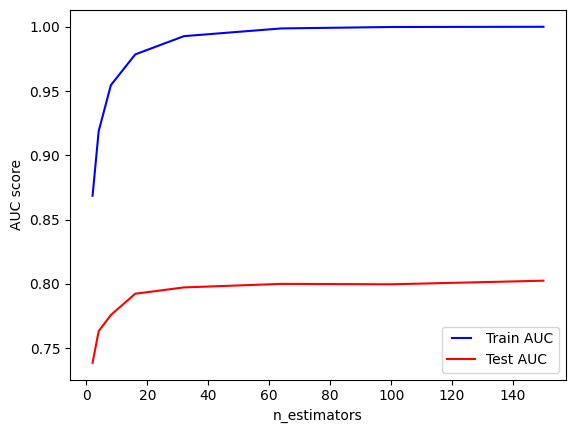

In [18]:
n_estimators = [2, 4, 8, 16, 32, 64, 100, 150]

train_results_nest = []
test_results_nest = []

for estimator in n_estimators:

     rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
     rf.fit(X_train_ht, y_train_ht)
     train_pred = rf.predict(X_train_ht)
     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ht, train_pred)
     roc_auc = auc(false_positive_rate, true_positive_rate)
     train_results_nest.append(roc_auc)
     y_pred = rf.predict(X_test)
     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
     roc_auc = auc(false_positive_rate, true_positive_rate)
     test_results_nest.append(roc_auc)

line1, = plt.plot(n_estimators, train_results_nest, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results_nest, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


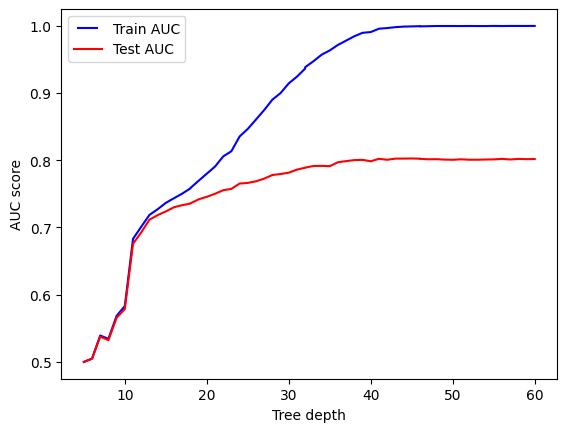

In [19]:
max_depths = np.linspace(5, 60, 60, endpoint=True).astype(int)

train_results_max = []
test_results_max = []

for max_depth in max_depths:

   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train_ht, y_train_ht)
   train_pred = rf.predict(X_train_ht)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ht, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results_max.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results_max.append(roc_auc)


line1, = plt.plot(max_depths, train_results_max, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results_max, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

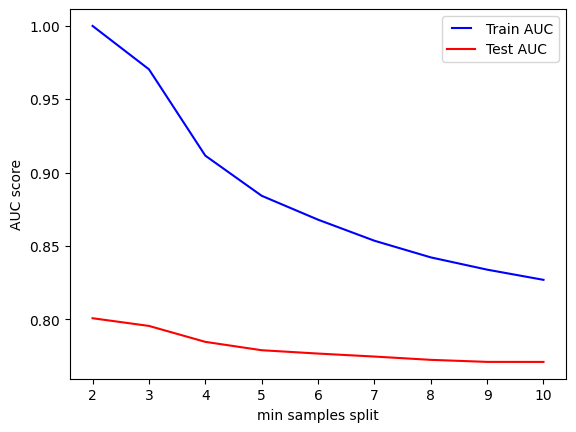

In [20]:
min_samples_splits = np.arange(2, 11)

train_results_splits = []
test_results_splits = []

for min_samples_split in min_samples_splits:
   
   rf = RandomForestClassifier(min_samples_split=min_samples_split, n_jobs=-1)
   rf.fit(X_train_ht, y_train_ht)
   train_pred = rf.predict(X_train_ht)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ht, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results_splits.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results_splits.append(roc_auc)


line1, = plt.plot(min_samples_splits, train_results_splits, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results_splits, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()


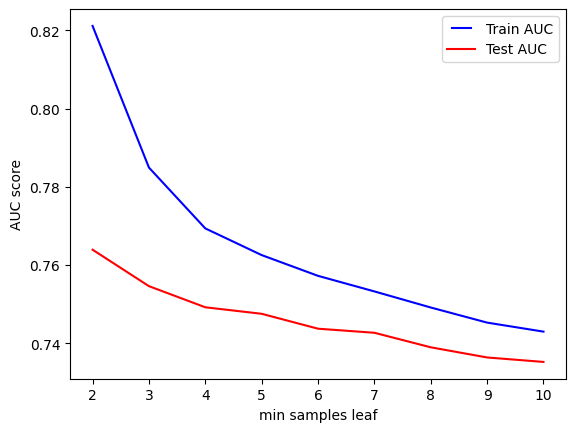

In [21]:
min_samples_leafs = np.arange(2, 11)

train_results_leafs = []
test_results_leafs = []

for min_samples_leaf in min_samples_leafs:
   
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_jobs=-1)
   rf.fit(X_train_ht, y_train_ht)
   train_pred = rf.predict(X_train_ht)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ht, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results_leafs.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results_leafs.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results_leafs, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results_leafs, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [22]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_recall_curve, precision_recall_fscore_support

In [23]:
# Scorers
f1_scorer_beta2 = make_scorer(fbeta_score,
                          beta=2,
                          greater_is_better = True,
                          pos_label=0)

f1_scorer = make_scorer(fbeta_score, greater_is_better = True)

In [25]:
# NESUBALANSUOTI DUOMENYS

f1_scorer_beta2 = make_scorer(fbeta_score,
                          beta=2,
                          greater_is_better = True,
                          pos_label=0)


param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [ 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=f1_scorer_beta2, random_state=42)

random_search.fit(X_train_ht, y_train_ht)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))

# {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'log_loss'}
#Best cross-validation accuracy: 0.991

# {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}

Best Parameters found:
{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}
Best cross-validation accuracy: 0.991


Accuracy: 0.9815402895557646
F1: 0.8648928460503158
AUC: 0.9707054188102917


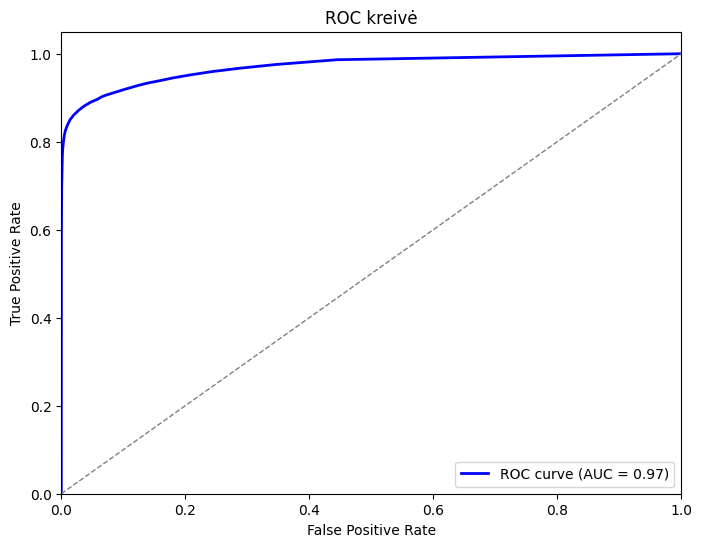

In [8]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1:", f1)

y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = auc(fpr, tpr)
print("AUC:", auc_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()



# Under sampling metodai

- RandomUnderSampler()
- EditedNearestNeighbours()
- TomekLinks()

In [26]:
f1_scorer = make_scorer(f1_score)

In [45]:
rus =  RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_rus).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)

X_train_ht_rus, X_test_ht_rus, y_train_ht_rus, y_test_ht_rus = train_test_split(X_train_rus,y_train_rus, stratify=y_train_rus, test_size=0.8, random_state=42)

# 0    76796
# 1    76796

Class Counts after RandomUnderSampler:
Churn
0    74562
1    74562
Name: count, dtype: int64


In [46]:
X_train_rus_df = pd.DataFrame(X_train_rus)
y_train_rus_df = pd.DataFrame(y_train_rus)

df = pd.concat([X_train_rus_df, y_train_rus_df], axis=1)

df.to_csv('train_data_rus.txt', sep='\t', index=False)

In [ ]:
# df_rus = pd.read_csv('train_data_rus.txt', sep='\t')

# X_train_rus = df_rus.drop('Churn', axis=1)  
# y_train_rus = df_rus['Churn']              

# X_train_ht_rus, X_test_ht_rus, y_train_ht_rus, y_test_ht_rus = train_test_split(X_train_rus, y_train_rus, stratify=y_train_rus, test_size=0.7, random_state=42)

In [47]:
# rus

f1_scorer = make_scorer(f1_score, greater_is_better = True)


param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_jobs=-1, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_rus, y_train_ht_rus)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))


# Best Parameters found:
# {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'log_loss'}
# Best cross-validation accuracy: 0.842

Best Parameters found:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 70, 'criterion': 'entropy'}
Best cross-validation accuracy: 0.836


Accuracy: 0.9268521622527657
F1: 0.6479352821391612
AUC: 0.9602812451902666


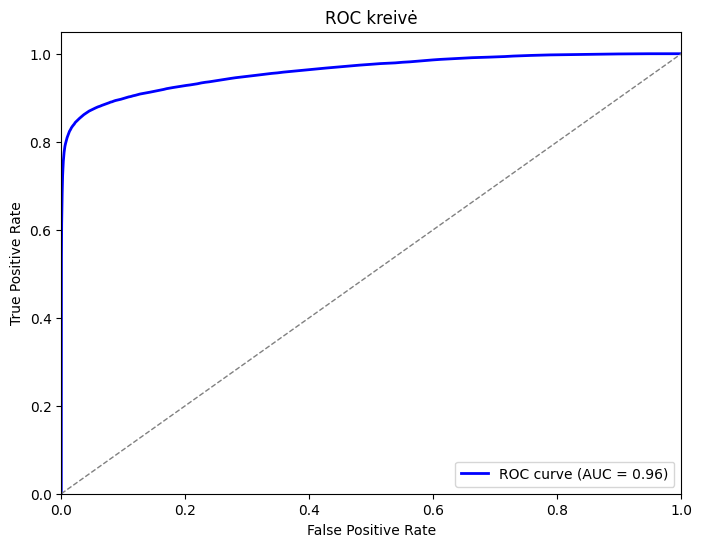

In [24]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_model.fit(X_train_rus, y_train_rus)

y_pred_rus = best_model.predict(X_test)

accuracy_rus = accuracy_score(y_test, y_pred_rus)
print("Accuracy:", accuracy_rus)

f1_rus = f1_score(y_test, y_pred_rus)
print("F1:", f1_rus)

y_prob_rus = best_model.predict_proba(X_test)[:, 1]
fpr_rus, tpr_rus, thresholds_rus = roc_curve(y_test, y_prob_rus)
auc_score_rus = auc(fpr_rus, tpr_rus)
print("AUC:", auc_score_rus)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rus, tpr_rus, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_rus)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()

In [25]:
############################################

In [30]:
enn =  EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_enn).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)

X_train_ht_enn, X_test_ht_enn, y_train_ht_enn, y_test_ht_enn = train_test_split(X_train_enn,y_train_enn, stratify=y_train_enn, test_size=0.3, random_state=42)

# 0    823137
# 1     76796

Class Counts after RandomUnderSampler:
Churn
0    811730
1     74562
Name: count, dtype: int64


In [31]:
X_train_enn_df = pd.DataFrame(X_train_enn)
y_train_enn_df = pd.DataFrame(y_train_enn)

df = pd.concat([X_train_enn_df, y_train_enn_df], axis=1)

df.to_csv('train_data_enn.txt', sep='\t', index=False)

In [ ]:
# df_enn = pd.read_csv('train_data_enn.txt', sep='\t')

# X_train_enn = df_enn.drop('Churn', axis=1)  
# y_train_enn = df_enn['Churn']              

# X_train_ht_enn, X_test_ht_enn, y_train_ht_enn, y_test_ht_enn = train_test_split(X_train_enn, y_train_enn, stratify=y_train_enn, test_size=0.7, random_state=42)

In [32]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_enn, y_train_ht_enn)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))

# {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}
# Best cross-validation accuracy: 0.741

# Best Parameters found:
# {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 80, 'criterion': 'entropy'}
# Best cross-validation accuracy: 0.736

Best Parameters found:
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 80, 'criterion': 'entropy'}
Best cross-validation accuracy: 0.736


Accuracy: 0.9595662778734669
F1: 0.717230674707756
AUC: 0.9164796087053662


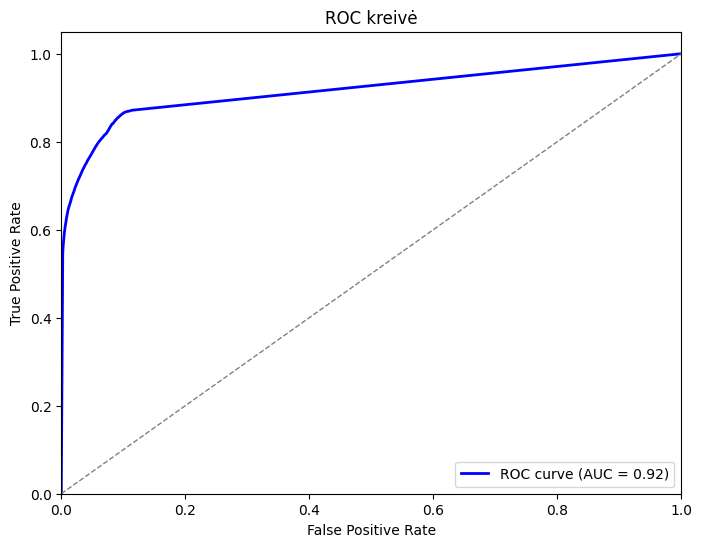

In [28]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=40,
    max_features=None,
    min_samples_leaf=7,
    min_samples_split=4,
    n_estimators=100,
    random_state=42
)

best_model.fit(X_train_enn, y_train_enn)

y_pred_enn = best_model.predict(X_test)

accuracy_enn = accuracy_score(y_test, y_pred_enn)
print("Accuracy:", accuracy_enn)

f1_enn = f1_score(y_test, y_pred_enn)
print("F1:", f1_enn)

y_prob_enn = best_model.predict_proba(X_test)[:, 1]
fpr_enn, tpr_enn, thresholds_enn = roc_curve(y_test, y_prob_enn)
auc_score_enn = auc(fpr_enn, tpr_enn)
print("AUC:", auc_score_enn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_enn, tpr_enn, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_enn)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()

In [29]:
##############################################################

# Over sampling metodai

- RandomOverSampler()
- SMOTE()
- ADASYN()

In [48]:
ros =  RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_ros).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)

X_train_ht_ros, X_test_ht_ros, y_train_ht_ros, y_test_ht_ros = train_test_split(X_train_ros,y_train_ros, stratify=y_train_ros, test_size=0.7, random_state=42)

# 0    932451
# 1    932451

MemoryError: Unable to allocate 521. MiB for an array with shape (69, 989721) and data type float64

In [ ]:
X_train_ros_df = pd.DataFrame(X_train_ros)
y_train_ros_df = pd.DataFrame(y_train_ros)

df = pd.concat([X_train_ros_df, y_train_ros_df], axis=1)

df.to_csv('train_data_ros.txt', sep='\t', index=False)

In [ ]:
# df_ros = pd.read_csv('train_data_ros.txt', sep='\t')

# X_train_ros = df_ros.drop('Churn', axis=1)  
# y_train_ros = df_ros['Churn']              

# X_train_ht_ros, X_test_ht_ros, y_train_ht_ros, y_test_ht_ros = train_test_split(X_train_ros, y_train_ros, stratify=y_train_ros, test_size=0.7, random_state=42)

In [ ]:
f1_scorer = make_scorer(f1_score)

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(n_jobs = -1, random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_jobs = -1, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_ros, y_train_ht_ros)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))

# Best Parameters found:
# {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'log_loss'}
# Best cross-validation accuracy: 0.938

Accuracy: 0.9819020426092686
F1: 0.8692500417571405
AUC: 0.9712361162564531


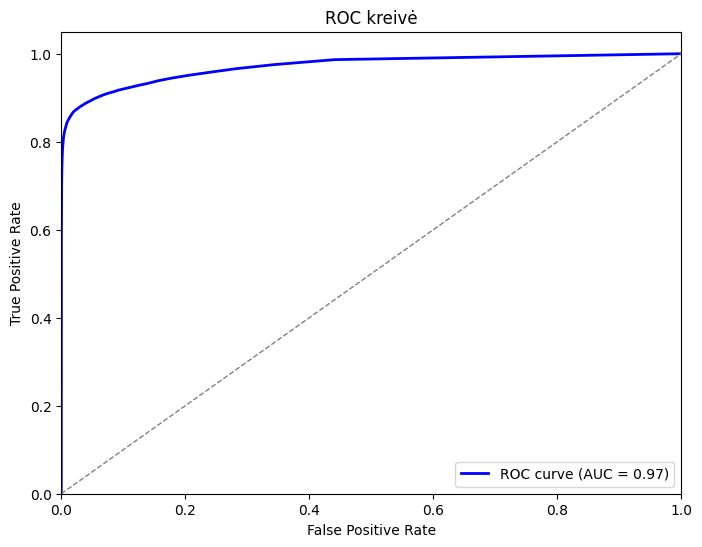

In [16]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_model.fit(X_train_ros, y_train_ros)

y_pred_ros = best_model.predict(X_test)

accuracy_ros = accuracy_score(y_test, y_pred_ros)
print("Accuracy:", accuracy_ros)

f1_ros = f1_score(y_test, y_pred_ros)
print("F1:", f1_ros)

y_prob_ros = best_model.predict_proba(X_test)[:, 1]
fpr_ros, tpr_ros, thresholds_ros = roc_curve(y_test, y_prob_ros)
auc_score_ros = auc(fpr_ros, tpr_ros)
print("AUC:", auc_score_ros)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ros, tpr_ros, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_ros)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()

In [ ]:
############################################################################

In [34]:
sm =  SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_sm).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)

X_train_ht_sm, X_test_ht_sm, y_train_ht_sm, y_test_ht_sm = train_test_split(X_train_sm,y_train_sm, stratify=y_train_sm, test_size=0.8, random_state=42)

Class Counts after RandomUnderSampler:
Churn
0    915159
1    915159
Name: count, dtype: int64


In [35]:
X_train_sm_df = pd.DataFrame(X_train_sm)
y_train_sm_df = pd.DataFrame(y_train_sm)

df = pd.concat([X_train_sm_df, y_train_sm_df], axis=1)

df.to_csv('train_data_sm.txt', sep='\t', index=False)

In [ ]:
# df_sm = pd.read_csv('train_data_sm.txt', sep='\t')

# X_train_sm = df_sm.drop('Churn', axis=1)  
# y_train_sm = df_sm['Churn']              

# X_train_ht_sm, X_test_ht_sm, y_train_ht_sm, y_test_ht_sm = train_test_split(X_train_sm, y_train_sm, stratify=y_train_sm, test_size=0.7, random_state=42)

In [37]:
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_sm, y_train_ht_sm)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))

#Best Parameters found:
# {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'log_loss'}
# Best cross-validation accuracy: 0.931

# Best Parameters found:
# {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'log_loss'}
# Best cross-validation accuracy: 0.951

Best Parameters found:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'log_loss'}
Best cross-validation accuracy: 0.951


Accuracy: 0.9785265932236697
F1: 0.8557002143989062
AUC: 0.9743769272167117


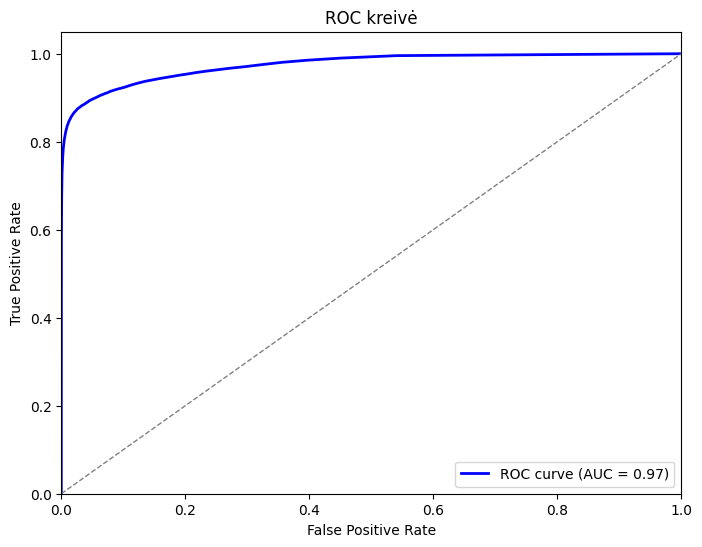

In [18]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    n_jobs = -1
)

best_model.fit(X_train_sm, y_train_sm)

y_pred_sm = best_model.predict(X_test)

accuracy_sm = accuracy_score(y_test, y_pred_sm)
print("Accuracy:", accuracy_sm)

f1_sm = f1_score(y_test, y_pred_sm)
print("F1:", f1_sm)

y_prob_sm = best_model.predict_proba(X_test)[:, 1]
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_prob_sm)
auc_score_sm = auc(fpr_sm, tpr_sm)
print("AUC:", auc_score_sm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sm, tpr_sm, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_sm)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()

In [ ]:
##########################################################################

# Combined sampling metodai

- SMOTEENN()
- SMOTETomek()


In [38]:
smt =  SMOTETomek()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_smt).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)


X_train_ht_smt, X_test_ht_smt, y_train_ht_smt, y_test_ht_smt = train_test_split(X_train_smt, y_train_smt, stratify=y_train_smt, test_size=0.7, random_state=42)



Class Counts after RandomUnderSampler:
Churn
0    906779
1    906779
Name: count, dtype: int64


In [39]:
X_train_smt_df = pd.DataFrame(X_train_smt)
y_train_smt_df = pd.DataFrame(y_train_smt)

df = pd.concat([X_train_smt_df, y_train_smt_df], axis=1)

df.to_csv('train_data_smt.txt', sep='\t', index=False)

In [ ]:
# df_smt = pd.read_csv('train_data_smt.txt', sep='\t')

# X_train_smt = df_smt.drop('Churn', axis=1)  
# y_train_smt = df_smt['Churn']              

# X_train_ht_smt, X_test_ht_smt, y_train_ht_smt, y_test_ht_smt = train_test_split(X_train_smt, y_train_smt, stratify=y_train_smt, test_size=0.7, random_state=42)

In [41]:
f1_scorer = make_scorer(f1_score, greater_is_better=True)

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_smt, y_train_ht_smt)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))

Best Parameters found:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'log_loss'}
Best cross-validation accuracy: 0.962


In [ ]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
)

best_model.fit(X_train_smt, y_train_smt)

y_pred_smt = best_model.predict(X_test)

accuracy_smt = accuracy_score(y_test, y_pred_smt)
print("Accuracy:", accuracy_smt)

f1_smt = f1_score(y_test, y_pred_smt)
print("F1:", f1_smt)

y_prob_smt = best_model.predict_proba(X_test)[:, 1]
fpr_smt, tpr_smt, thresholds_smt = roc_curve(y_test, y_prob_smt)
auc_score_smt = auc(fpr_smt, tpr_smt)
print("AUC:", auc_score_smt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_smt, tpr_smt, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_smt)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()

In [42]:
sme =  SMOTEENN()
X_train_sme, y_train_sme = sme.fit_resample(X_train, y_train)

class_counts_resampled = pd.Series(y_train_sme).value_counts()

print("Class Counts after RandomUnderSampler:")
print(class_counts_resampled)

X_train_ht_sme, X_test_ht_sme, y_train_ht_sme, y_test_ht_sme = train_test_split(X_train_sme, y_train_sme, stratify=y_train_sme, test_size=0.7, random_state=42)


Class Counts after RandomUnderSampler:
Churn
1    835396
0    716271
Name: count, dtype: int64


In [43]:
X_train_sme_df = pd.DataFrame(X_train_sme)
y_train_sme_df = pd.DataFrame(y_train_sme)

df = pd.concat([X_train_sme_df, y_train_sme_df], axis=1)

df.to_csv('train_data_sme.txt', sep='\t', index=False)

In [28]:
# df_sme = pd.read_csv('train_data_sme.txt', sep='\t')

# X_train_sme = df_sme.drop('Churn', axis=1)  
# y_train_sme = df_sme['Churn']              

# X_train_ht_sme, X_test_ht_sme, y_train_ht_sme, y_test_ht_sme = train_test_split(X_train_sme, y_train_sme, stratify=y_train_sme, test_size=0.7, random_state=42)

In [44]:
f1_scorer = make_scorer(f1_score, greater_is_better=True)

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=f1_scorer, random_state=42)

random_search.fit(X_train_ht_sme, y_train_ht_sme)

print("Best Parameters found:")
print(random_search.best_params_)

print("Best cross-validation accuracy: {:.3f}".format(random_search.best_score_))


# Best Parameters found:
# {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 90, 'criterion': 'log_loss'}
# Best cross-validation accuracy: 0.972

C:\Users\evelina.voleiso\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
19 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evelina.voleiso\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evelina.voleiso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\evelina.voleiso\

Best Parameters found:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'log_loss'}
Best cross-validation accuracy: 0.971


In [ ]:

best_model = RandomForestClassifier(
    bootstrap=False,
    criterion='log_loss',
    max_depth=90,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
)

best_model.fit(X_train_sme, y_train_sme)

y_pred_sme = best_model.predict(X_test)

accuracy_sme = accuracy_score(y_test, y_pred_sme)
print("Accuracy:", accuracy_sme)

f1_sme = f1_score(y_test, y_pred_sme)
print("F1:", f1_sme)

y_prob_sme = best_model.predict_proba(X_test)[:, 1]
fpr_sme, tpr_sme, thresholds_sme = roc_curve(y_test, y_prob_sme)
auc_score_sme = auc(fpr_sme, tpr_sme)
print("AUC:", auc_score_sme)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sme, tpr_sme, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score_sme)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kreivė')
plt.legend(loc='lower right')
plt.show()